## Exploratory Analysis and Square Meter Price Correlations (Rent) 

### 1. Libraries and setup jupyter cells and plots

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

### 2. Initial Exploration Analysis and select data of interest

In [4]:
# Database import , version with Rent and Purchase marketing type and enriched with lieferando data. 
df = pd.read_csv("data/20200124_is24_buyrent_plus_lieferando.csv", sep=";")
df.head(3).transpose()

,0,1,2
Unnamed: 0,0,1,2
city,Berlin,Berlin,Berlin
hasCourtage,NO,NO,NO
houseNo,13,13,13
id,115408865,115408859,115408828
latitude,52.5504,52.5504,52.5504
longitude,13.2143,13.2143,13.2143
marketingType,PURCHASE,PURCHASE,PURCHASE
n_page_is24,1,1,1
n_room,4,4,4


In [5]:
# Filter RENT market for analysis
df = df[df["marketingType"] == "RENT"]

In [6]:
# standardization of the price column per square meter to reuse the code for other markets. 
df["price_per_qm"] = df["purchase_price_per_qm"] 
df.price_per_qm.fillna(df.rent_cold_per_qm, inplace=True)

In [7]:
# Show percent completeness for each column
[[column, df[column].count() / len(df)] for column in df if df[column].count() / len(df) >= 0.3]

[['Unnamed: 0', 1.0],
 ['city', 1.0],
 ['houseNo', 0.8549618320610687],
 ['id', 1.0],
 ['latitude', 0.8412213740458016],
 ['longitude', 0.8412213740458016],
 ['marketingType', 1.0],
 ['n_page_is24', 1.0],
 ['n_room', 1.0],
 ['postcode', 1.0],
 ['privateOffer', 1.0],
 ['qm', 1.0],
 ['quarter', 1.0],
 ['rent_cold', 1.0],
 ['rent_cold_per_qm', 1.0],
 ['street', 0.8549618320610687],
 ['title', 1.0],
 ['n_restaurant', 0.9960305343511451],
 ['price_per_qm', 1.0]]

In [8]:
# Select data of interest 
df_analysis = df[['n_restaurant','postcode','price_per_qm']]

In [9]:
# Decribe price per square meter
print(df_analysis['price_per_qm'].describe())

count    3275.000000
mean       15.302626
std         6.641701
min         5.100000
25%        10.800000
50%        14.000000
75%        18.200000
max        76.200000
Name: price_per_qm, dtype: float64


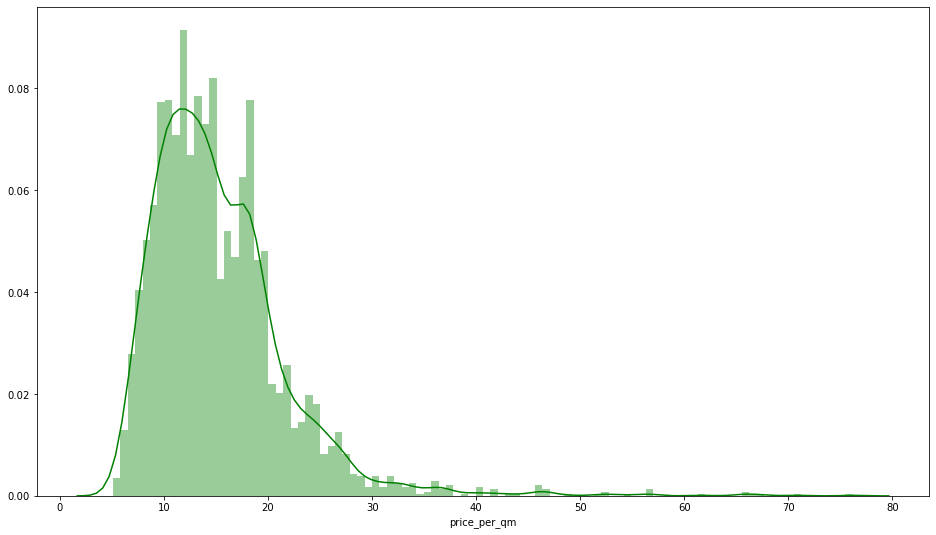

In [10]:
# Distribution of price per square meter
plt.figure(figsize=(16, 9))
sns.distplot(df_analysis['price_per_qm'], color='g', bins=100, hist_kws={'alpha': 0.4});

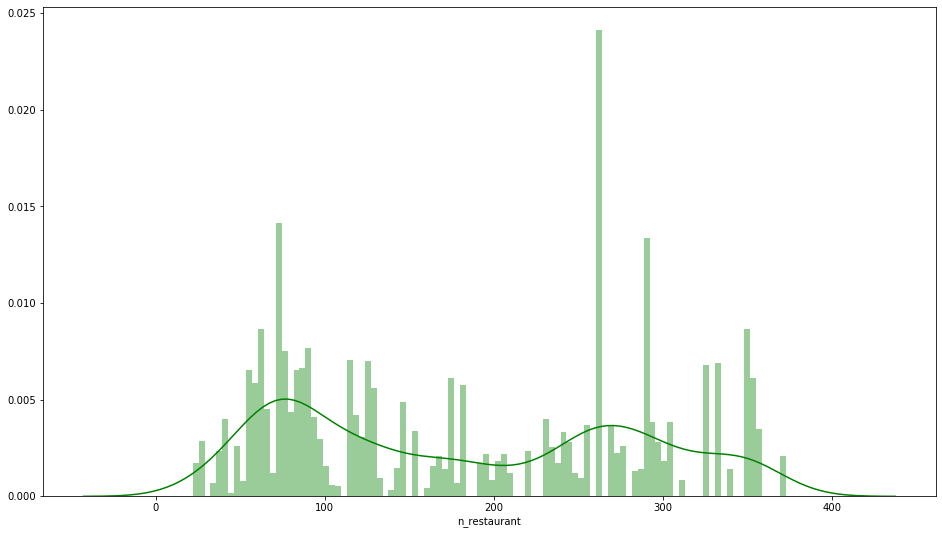

In [15]:
# Distribution of number of restaurantes near from each property
plt.figure(figsize=(16, 9))
sns.distplot(df_analysis['n_restaurant'], color='g', bins=100, hist_kws={'alpha': 0.4});

### 3. Clean outliers based on IQR metric

In [16]:
# Define new dataframe with main metrics to identify outliers
df_descr = df_analysis[["n_restaurant","price_per_qm"]].describe().transpose()

In [17]:
# Keep only columns to clean outliers and add IQR metric
df_descr = df_descr[["25%","75%"]].assign(IQR=df_descr["75%"] - df_descr["25%"])

In [18]:
df_descr

,25%,75%,IQR
n_restaurant,85.0,269.0,184.0
price_per_qm,10.8,18.2,7.4


In [19]:
# 1. create new empty DataFrame df_outliers with the same columns
df_outliers = pd.DataFrame(columns=df_analysis.columns)

# 2. iterate over all numerical columns
for num_col in df_descr.index:
    iqr = df_descr.loc[num_col, "IQR"]
    
    # 3. set tolerance factor and calculate cutoff
    t_factor = 3
    cutoff = iqr * t_factor
    
    # 4. set lower and upper threshold
    lower_threshold = df_descr.loc[num_col, "25%"] - cutoff
    upper_threshold = df_descr.loc[num_col, "75%"] + cutoff
    
    # 5. identify outliers and mark in outliers column
    df_analysis[num_col + "_outlier"] = df_analysis[num_col].lt(lower_threshold) | df_analysis[num_col].gt(upper_threshold)

/home/psmorelli/anaconda3/envs/code_red/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
# Select data without outliers in square meter price and number of restaurantes
df_analysis = df_analysis[(df_analysis["n_restaurant_outlier"] == False) & (df_analysis["price_per_qm_outlier"] == False)]

In [21]:
df_analysis = df_analysis.drop (columns=["n_restaurant_outlier","price_per_qm_outlier"])

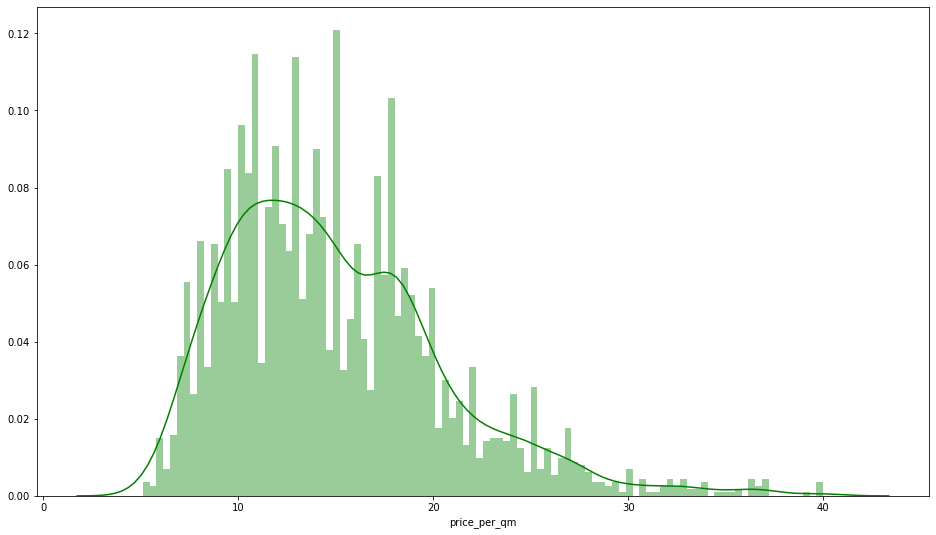

In [23]:
# Distribution of price per square meter without outliers
plt.figure(figsize=(16, 9))
sns.distplot(df_analysis['price_per_qm'], color='g', bins=100, hist_kws={'alpha': 0.4});

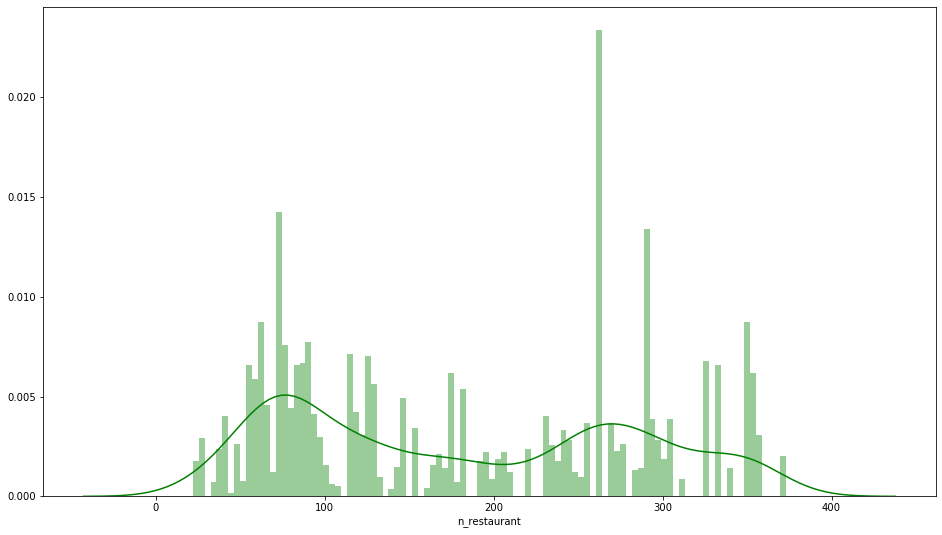

In [24]:
# Distribution of number of restaurantes near from each property without outliers
plt.figure(figsize=(16, 9))
sns.distplot(df_analysis['n_restaurant'], color='g', bins=100, hist_kws={'alpha': 0.4});

### 4. Sumarize data

In [25]:
df_analysis = df.groupby(["n_restaurant",'postcode']).mean()

### 5. Correlation analysis

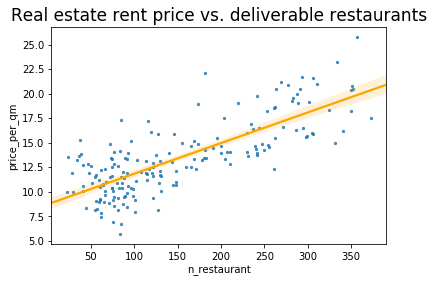

In [26]:
# Plot correlation char with title
g = (sns.regplot(data = df_analysis.reset_index(),
                 x = 'n_restaurant',
                 y = 'price_per_qm',
                 line_kws = {"color": "orange"},
                 scatter_kws ={"s": 5}))

g.set_title("Real estate rent price vs. deliverable restaurants", fontsize = 17);
plt.savefig("Presentation/rentprice.png")

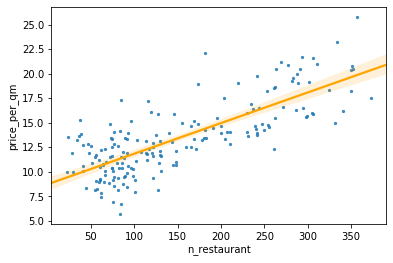

In [27]:
# Plot correlation char without title
g = (sns.regplot(data = df_analysis.reset_index(),
                 x = 'n_restaurant',
                 y = 'price_per_qm',
                 line_kws = {"color": "orange"},
                 scatter_kws ={"s": 5}))